## Задание

https://www.kaggle.com/competitions/urfu-engai-2023-competition-3-classification

Инструкции  
Подробная инструкция в прошлых семестрах. Вы уже взрослые  

Вкратце:  
Проходим по ссылке Cоревнования.  Принять участие, да, далее согласен. И т.д.  
Ладно, как загружать будет блокнот  
Обучаем модель  
- грузим тренировочные данные   
- выполняем предварительный анализ  
- убираем мусорные признаки   
- обучаем модель на ваш выбор  
- работаем с признаками, крутим гиперпараметры  
- оцениваем точность модели  

Применяем модель к тестовым данным  
Загружаем данные на платформу. 
Если метрика на платформе - норм, загружаем решение сюда. Если нет - повторяем пункты 3-5.  


Оцениваться будет не только итоговая метрика на платформе, но и качество оформления решения (критерии оценки приложены в задании)  
Дедлайн - до конца года, мы никуда не спешим, но и не сильно тормозим.

### UrFU EngAI 2023 Competition 3 Classification
(Поиск полезной информации в мусоре Часть 2)

**Description**

*Предсказание классов*  
В этом семестре вам предстоит опять предсказывать классы (только не известно чего). Это секрет
Мультикласс. УРА!  
Дело в том что для я генерировал данные по определенным законам, которые в целом можно разделить с помощью даже относительно простых моделей (по отдельности)  
При этом (чтобы не совсем скучно было)  

- Добавил много "мусорных" признаков  
- Перемешал колонки и спрятал имена  
 
Если вы делали по серьезному соревнование для регрессии то мусорные признаки вы точно найдёте  

И вам останется понять как из адекватных признаков извлечь полезную информацию (Я ПРОВЕРИЛ CatBoost из коробки даёт где-то 0.5)  

Спасибо команде курса https://stepik.org/course/108888/promo за шикарную идею (НЕ РЕКЛАМА)  

**Evaluation**  

*Целевая метрика*  
F1_score макроусреднение >= 0.99

**Files**  

- Train.csv - тренировочный набор
- Test.csv - тестовый набор
- Target.csv - правильные ответы для тренировочного набора
- submission.csv - пример файла загрузки с константным предсказанием

### Функции

Оптимизация объема памяти, занимаемого датасетом

In [1]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [2]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances)))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [28]:
def get_scale(df, model):
    scal = model.fit_transform(df)
    df = scal
    return df

### Import библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [4]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

# 6. Всякие разности
from sklearn.preprocessing import LabelEncoder

In [5]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [6]:
import warnings 
warnings.simplefilter("ignore", UserWarning)

### Считываем файлы в DataFrame

In [7]:
target = pd.read_csv('./Data/3semestr/Classification/target.csv')
train = pd.read_csv('./Data/3semestr/Classification/train.csv')
test = pd.read_csv('./Data/3semestr/Classification/test.csv')
submission_clf = pd.read_csv('./Data/3semestr/Classification/submission.csv')

### Первичный анализ данных

**Посмотрим на тренировочный датасет**

In [464]:
train.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26
0,6002,0.284313,4.219830,1.221181,-0.033805,0.954967,3.717548,-5.371620,8,-8.114714,...,0.484978,5.709929,0.419168,1,5.902307,0.025756,9,0.400968,0.200678,6.044972
1,4895,0.688878,-3.151896,-0.084847,0.837584,0.452307,5.007462,1.150248,8,-2.975189,...,2.378392,2.316058,-0.143171,1,4.830141,3.561733,9,0.025996,0.123487,6.032597
2,4072,1.924478,-0.705611,0.658260,0.367463,0.784745,3.570199,2.622817,8,2.182189,...,5.225690,9.047253,0.691782,1,4.018763,0.292715,9,0.223886,0.107620,8.970672
3,4457,2.012251,2.732572,2.831323,0.470805,-1.067754,5.178344,2.087656,8,-1.931267,...,1.050520,4.689684,-0.183979,1,4.378999,4.398202,9,0.199916,0.556204,4.974319
4,7880,1.405036,-4.750124,-6.526375,-0.770324,0.549478,3.790355,-0.193960,8,-7.969943,...,0.479188,6.697533,2.232350,1,7.818239,3.371134,9,-0.886806,0.576564,4.763733


In [465]:
train.shape

(7000, 28)

In [466]:
train.describe()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.0,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.0,7000.000000,7000.000000,7000.0,7000.000000,7000.000000,7000.000000
mean,4968.743429,1.097403,-0.003965,-0.014075,0.003279,0.017431,3.068403,-0.017493,8.0,-0.005691,...,3.684006,4.819972,-0.011186,1.0,4.911189,2.416883,9.0,-0.003210,0.308998,4.620639
std,2904.021294,0.633400,3.010400,2.990256,1.001340,1.002073,1.791683,1.988456,0.0,3.967632,...,2.134587,2.749563,0.993175,0.0,2.893123,1.408997,0.0,1.715576,0.179819,2.656091
min,0.000000,0.000180,-12.103301,-13.122128,-3.948000,-3.624920,0.000729,-6.842591,8.0,-14.979111,...,0.000688,0.002313,-3.627208,1.0,0.000116,0.000387,9.0,-5.734548,0.000073,0.002104
25%,2439.750000,0.539736,-2.035952,-2.032544,-0.684205,-0.665963,1.527605,-1.413457,8.0,-2.718759,...,1.825096,2.508460,-0.665404,1.0,2.404984,1.200663,9.0,-1.157398,0.149744,2.329980
50%,4973.500000,1.108161,-0.057540,-0.029501,0.011015,0.035113,3.040380,-0.037297,8.0,-0.026808,...,3.670112,4.842153,-0.006700,1.0,4.895386,2.394693,9.0,-0.010549,0.309181,4.598197
75%,7478.250000,1.641799,2.018083,2.038669,0.669680,0.702519,4.628539,1.348836,8.0,2.727701,...,5.550752,7.180034,0.659616,1.0,7.379020,3.648281,9.0,1.123445,0.462817,6.938378
max,9999.000000,2.191886,11.715167,10.392956,3.630943,4.077853,6.174218,7.910230,8.0,14.660918,...,7.369404,9.583743,3.599812,1.0,9.997177,4.875826,9.0,6.856501,0.620156,9.247000


In [467]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          7000 non-null   int64  
 1   feature 0   7000 non-null   float64
 2   feature 1   7000 non-null   float64
 3   feature 2   7000 non-null   float64
 4   feature 3   7000 non-null   float64
 5   feature 4   7000 non-null   float64
 6   feature 5   7000 non-null   float64
 7   feature 6   7000 non-null   float64
 8   feature 7   7000 non-null   int64  
 9   feature 8   7000 non-null   float64
 10  feature 9   7000 non-null   float64
 11  feature 10  7000 non-null   float64
 12  feature 11  7000 non-null   float64
 13  feature 12  7000 non-null   float64
 14  feature 13  7000 non-null   float64
 15  feature 14  7000 non-null   float64
 16  feature 15  7000 non-null   float64
 17  feature 16  7000 non-null   float64
 18  feature 17  7000 non-null   float64
 19  feature 18  7000 non-null  

Процентный список пропущенных данных

In [468]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    if pct_missing !=0:
        print('{} - {}%'.format(col, round(pct_missing*100)))
print('Больше пропущенных значений нет!')

Больше пропущенных значений нет!


Составим список признаков, у которых более 95% строк содержат одно и то же значение

In [469]:
trashhold = 0.95

In [470]:
num_rows = len(train.index)
low_information_cols = [] #

for col in train.columns:
    cnts = train[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > trashhold:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

feature 7: 100.00000%
feature 7
8    7000
Name: count, dtype: int64

feature 20: 100.00000%
feature 20
1    7000
Name: count, dtype: int64

feature 23: 100.00000%
feature 23
9    7000
Name: count, dtype: int64



Удалим эти признаки

In [471]:
train = train.drop(low_information_cols, axis=1)

Построим тепловую карту корреляции признаков

<Axes: >

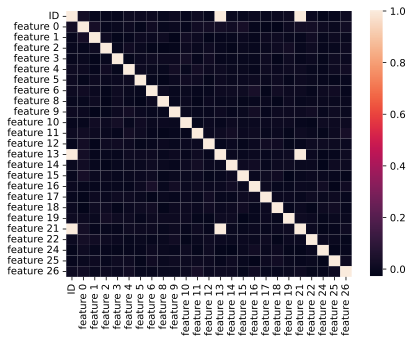

In [472]:
sns.heatmap(train.corr())

In [473]:
trashhold = 0.8

In [474]:
corr_cols = [] #

for col in train.columns:
    for col_2 in train.columns:
        if (col != col_2) and ((train[col].corr(train[col_2]) >= trashhold or train[col].corr(train[col_2]) <= -trashhold)):
            corr_cols.append(col)
            print(f'{col} - {col_2}: {train[col].corr(train[col_2])}')
            print()

ID - feature 13: 0.9999183987773577

ID - feature 21: 0.9999420425571247

feature 13 - ID: 0.9999183987773578

feature 13 - feature 21: 0.9999760471006798

feature 21 - ID: 0.9999420425571247

feature 21 - feature 13: 0.9999760471006797



Удалим лишние признаки

In [475]:
#corr_cols = list(set(corr_cols))

In [476]:
#df = train[['feature 7', 'feature 31', 'feature 83']]
#df.head()

In [477]:
train = train.drop(['feature 13'
                    , 'feature 21'
                   ], axis=1)

Посмотрим количество уникальных значений в столбце  
Выберем категориальные фичи
Выберем числовые значения

In [478]:
train = train.drop(['ID'], axis=1)

In [479]:
cat_col = []
num_col = []
for col in train.columns:
    print(f'Столбец "{col}": количество уникальных значений {train[col].nunique()}')

Столбец "feature 0": количество уникальных значений 7000
Столбец "feature 1": количество уникальных значений 7000
Столбец "feature 2": количество уникальных значений 7000
Столбец "feature 3": количество уникальных значений 7000
Столбец "feature 4": количество уникальных значений 7000
Столбец "feature 5": количество уникальных значений 7000
Столбец "feature 6": количество уникальных значений 7000
Столбец "feature 8": количество уникальных значений 7000
Столбец "feature 9": количество уникальных значений 7000
Столбец "feature 10": количество уникальных значений 7000
Столбец "feature 11": количество уникальных значений 7000
Столбец "feature 12": количество уникальных значений 7000
Столбец "feature 14": количество уникальных значений 7000
Столбец "feature 15": количество уникальных значений 7000
Столбец "feature 16": количество уникальных значений 7000
Столбец "feature 17": количество уникальных значений 7000
Столбец "feature 18": количество уникальных значений 7000
Столбец "feature 19": к

Посмотрим на значение дисперсии признаков, удали те, где дисперсия незначительная как малозначимые (меньше 10)

In [480]:
lowvar_col = []
for col in train.columns:
    if train[col].var(ddof=0) <= 2:
        lowvar_col.append(col)
        print(f'Столбец "{col}": значение дисперсии {train[col].var(ddof=0)}')

Столбец "feature 0": значение дисперсии 0.40113861617083024
Столбец "feature 3": значение дисперсии 1.0025377349341191
Столбец "feature 4": значение дисперсии 1.004007326956565
Столбец "feature 10": значение дисперсии 1.0402155509680886
Столбец "feature 11": значение дисперсии 0.004254692714161868
Столбец "feature 19": значение дисперсии 0.9862558414275313
Столбец "feature 22": значение дисперсии 1.9849884626999594
Столбец "feature 25": значение дисперсии 0.03233023371992701


Столбец "feature 0": значение дисперсии 0.40113861617083024  
Столбец "feature 1": значение дисперсии 9.061215607073521  
Столбец "feature 2": значение дисперсии 8.940353207421019  
Столбец "feature 3": значение дисперсии 1.0025377349341191  
Столбец "feature 4": значение дисперсии 1.004007326956565  
Столбец "feature 5": значение дисперсии 3.2096700996066407  
Столбец "feature 6": значение дисперсии 3.9533940308037554  
Столбец "feature 8": значение дисперсии 15.739857775533265  
Столбец "feature 9": значение дисперсии 2.5158669002958365  
Столбец "feature 10": значение дисперсии 1.0402155509680886  
Столбец "feature 11": значение дисперсии 0.004254692714161868  
Столбец "feature 12": значение дисперсии 15.90939591280151  
Столбец "feature 14": значение дисперсии 3.0410455708956556  
Столбец "feature 15": значение дисперсии 4.016144572663604  
Столбец "feature 16": значение дисперсии 8.83458961819213  
Столбец "feature 17": значение дисперсии 4.555812384887918  
Столбец "feature 18": значение дисперсии 7.559016377927056  
Столбец "feature 19": значение дисперсии 0.9862558414275313  
Столбец "feature 22": значение дисперсии 1.9849884626999594  
Столбец "feature 24": значение дисперсии 2.9427794190231085  
Столбец "feature 25": значение дисперсии 0.03233023371992701  
Столбец "feature 26": значение дисперсии 7.05381109790155  

Удалим "мусорные" фичи

In [481]:
train = train.drop(lowvar_col, axis=1)

In [482]:
train.head()

,feature 1,feature 2,feature 5,feature 6,feature 8,feature 9,feature 12,feature 14,feature 15,feature 16,feature 17,feature 18,feature 24,feature 26
0,4.219830,1.221181,3.717548,-5.371620,-8.114714,5.265328,11.258733,-0.446961,-1.817709,0.451489,0.484978,5.709929,0.400968,6.044972
1,-3.151896,-0.084847,5.007462,1.150248,-2.975189,1.613209,-1.704318,-0.564354,0.921713,2.372759,2.378392,2.316058,0.025996,6.032597
2,-0.705611,0.658260,3.570199,2.622817,2.182189,0.328124,3.220057,-0.993769,-0.818774,-1.073346,5.225690,9.047253,0.223886,8.970672
3,2.732572,2.831323,5.178344,2.087656,-1.931267,3.506177,5.513759,-3.324491,2.346552,-1.771180,1.050520,4.689684,0.199916,4.974319
4,-4.750124,-6.526375,3.790355,-0.193960,-7.969943,1.945758,2.836082,-2.859016,1.117392,0.351779,0.479188,6.697533,-0.886806,4.763733


In [483]:
features = train.columns
features

Index(['feature 1', 'feature 2', 'feature 5', 'feature 6', 'feature 8',
       'feature 9', 'feature 12', 'feature 14', 'feature 15', 'feature 16',
       'feature 17', 'feature 18', 'feature 24', 'feature 26'],
      dtype='object')

Применим MinMaxScaler к числовым признакам

In [32]:
train = get_scale(train, MinMaxScaler())

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Искомое количество классов

In [485]:
target['class_new'].nunique()

4

Избавимся от мульклассовой классификации объединив 2 и 0, и 3 и 1

In [486]:
target_two = target.copy()

In [487]:
target_two.head(2)

,ID,class_new
0,6002,2
1,4895,0


In [488]:
target_two.loc[target_two['class_new'] == 2, 'class_new'] = 0

In [489]:
target_two.loc[target_two['class_new'] == 3, 'class_new'] = 1

In [490]:
target_two['class_new'].unique()

array([0, 1], dtype=int64)

### Обучение модели

In [491]:
X = train
y = target_two['class_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=13)

In [492]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [493]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [494]:
grid_space={'max_features': [10,15,20], 
            'min_samples_leaf': [1,2,3], 
            'max_depth': [10,15,20]}

In [495]:
%%time
greed_search = GridSearchCV(forest,param_grid=grid_space,cv=skf, scoring='f1_macro', verbose = 1, return_train_score=True)
model_greed_search = greed_search.fit(X_train, y_train)

Fitting 6 folds for each of 27 candidates, totalling 162 fits


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

CPU times: total: 11min 11s
Wall time: 11min 13s


In [496]:
print(f'Лучшие параметры: {model_greed_search.best_params_}')
print(f'Best score is: {model_greed_search.best_score_}')

Лучшие параметры: {'max_depth': 15, 'max_features': 15, 'min_samples_leaf': 1}
Best score is: 0.9820418546177927


In [497]:
y_train_pred = model_greed_search.predict(X_train)
y_test_pred = model_greed_search.predict(X_test)
y_test_pred_probs = model_greed_search.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2439
           1       1.00      1.00      1.00      2461

    accuracy                           1.00      4900
   macro avg       1.00      1.00      1.00      4900
weighted avg       1.00      1.00      1.00      4900

TEST

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1061
           1       0.98      0.98      0.98      1039

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100

CONFUSION MATRIX

col_0         0     1
class_new            
0          1041    20
1            17  1022


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [498]:
print('f1 score', f1_score(y_train, y_train_pred, average='macro'))

f1 score 1.0


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [499]:
print('f1 score', f1_score(y_test, y_test_pred, average='macro'))

f1 score 0.9823795099780277


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

###  Применим обученную модель к тестовому набору данных

In [500]:
test = test[features]

In [501]:
test = get_scale(test, MinMaxScaler())

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [502]:
test

array([[0.49078345, 0.51679451, 0.10029384, ..., 0.42740326, 0.74260815,
        0.18250664],
       [0.44873069, 0.61043778, 0.68922157, ..., 0.7550928 , 0.44033425,
        0.57839313],
       [0.43621325, 0.71470215, 0.06608046, ..., 0.59848349, 0.4891663 ,
        0.44397487],
       ...,
       [0.63719049, 0.56521626, 0.42369594, ..., 0.05326655, 0.38837179,
        0.66582102],
       [0.36240487, 0.67448799, 0.57823353, ..., 0.54969875, 0.42730661,
        0.7125214 ],
       [0.2353141 , 0.3784166 , 0.32045583, ..., 0.22230332, 0.45110727,
        0.30039574]])

In [503]:
test_preds = model_greed_search.predict(test)

In [504]:
test_preds

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

### Сохраним полученные предсказания

In [505]:
submission_clf['class_new'] = test_preds

In [506]:
submission_clf

,ID,class_new
0,3132,1
1,4371,0
2,6647,0
3,5632,1
4,9703,0
...,...,...
2995,7604,1
2996,2727,1
2997,4552,0
2998,977,1


### Сохраним полученный промежуточный результат:

In [507]:
submission_clf.to_csv('urfu-engai-2023-competition-3-classification_1step.csv', index=False)

### Загрузим полученный результат

In [34]:
submission_clf = pd.read_csv('urfu-engai-2023-competition-3-classification_1step.csv')
submission_clf.head()

,ID,class_new
0,3132,1
1,4371,0
2,6647,0
3,5632,1
4,9703,0


### Повторим цикл, сначала для классов  2 и 0, а потом для 3 и 1

**2 и 0**

In [35]:
train2 = pd.read_csv('./Data/3semestr/Classification/train.csv')
train2.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26
0,6002,0.284313,4.219830,1.221181,-0.033805,0.954967,3.717548,-5.371620,8,-8.114714,...,0.484978,5.709929,0.419168,1,5.902307,0.025756,9,0.400968,0.200678,6.044972
1,4895,0.688878,-3.151896,-0.084847,0.837584,0.452307,5.007462,1.150248,8,-2.975189,...,2.378392,2.316058,-0.143171,1,4.830141,3.561733,9,0.025996,0.123487,6.032597
2,4072,1.924478,-0.705611,0.658260,0.367463,0.784745,3.570199,2.622817,8,2.182189,...,5.225690,9.047253,0.691782,1,4.018763,0.292715,9,0.223886,0.107620,8.970672
3,4457,2.012251,2.732572,2.831323,0.470805,-1.067754,5.178344,2.087656,8,-1.931267,...,1.050520,4.689684,-0.183979,1,4.378999,4.398202,9,0.199916,0.556204,4.974319
4,7880,1.405036,-4.750124,-6.526375,-0.770324,0.549478,3.790355,-0.193960,8,-7.969943,...,0.479188,6.697533,2.232350,1,7.818239,3.371134,9,-0.886806,0.576564,4.763733


In [36]:
df_1 = pd.merge(
    train2,
    target,
    how="left",
    on='ID',
)
df_1.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
0,6002,0.284313,4.219830,1.221181,-0.033805,0.954967,3.717548,-5.371620,8,-8.114714,...,5.709929,0.419168,1,5.902307,0.025756,9,0.400968,0.200678,6.044972,2
1,4895,0.688878,-3.151896,-0.084847,0.837584,0.452307,5.007462,1.150248,8,-2.975189,...,2.316058,-0.143171,1,4.830141,3.561733,9,0.025996,0.123487,6.032597,0
2,4072,1.924478,-0.705611,0.658260,0.367463,0.784745,3.570199,2.622817,8,2.182189,...,9.047253,0.691782,1,4.018763,0.292715,9,0.223886,0.107620,8.970672,2
3,4457,2.012251,2.732572,2.831323,0.470805,-1.067754,5.178344,2.087656,8,-1.931267,...,4.689684,-0.183979,1,4.378999,4.398202,9,0.199916,0.556204,4.974319,1
4,7880,1.405036,-4.750124,-6.526375,-0.770324,0.549478,3.790355,-0.193960,8,-7.969943,...,6.697533,2.232350,1,7.818239,3.371134,9,-0.886806,0.576564,4.763733,3


In [37]:
df_1 = df_1.loc[(df_1['class_new'] == 0) | (df_1['class_new'] == 2)]
df_1.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
0,6002,0.284313,4.219830,1.221181,-0.033805,0.954967,3.717548,-5.371620,8,-8.114714,...,5.709929,0.419168,1,5.902307,0.025756,9,0.400968,0.200678,6.044972,2
1,4895,0.688878,-3.151896,-0.084847,0.837584,0.452307,5.007462,1.150248,8,-2.975189,...,2.316058,-0.143171,1,4.830141,3.561733,9,0.025996,0.123487,6.032597,0
2,4072,1.924478,-0.705611,0.658260,0.367463,0.784745,3.570199,2.622817,8,2.182189,...,9.047253,0.691782,1,4.018763,0.292715,9,0.223886,0.107620,8.970672,2
5,5687,0.547548,-1.429901,-0.106532,-0.298815,1.231137,4.423871,1.232094,8,5.498164,...,9.422421,0.071642,1,5.582318,0.275169,9,0.501662,0.156752,8.931144,0
6,2161,2.096231,3.351338,-4.389428,-1.476092,-1.787271,1.631655,0.538942,8,-2.159392,...,2.670114,-0.416967,1,2.112318,2.665370,9,0.070781,0.058229,5.298785,0


In [38]:
df_1.shape

(3500, 29)

Составим список признаков, у которых более 95% строк содержат одно и то же значение

In [39]:
trashhold = 0.95

In [40]:
num_rows = len(df_1.index)
low_information_cols = [] #

for col in df_1.columns:
    cnts = df_1[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > trashhold:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

feature 7: 100.00000%
feature 7
8    3500
Name: count, dtype: int64

feature 20: 100.00000%
feature 20
1    3500
Name: count, dtype: int64

feature 23: 100.00000%
feature 23
9    3500
Name: count, dtype: int64



Удалим эти признаки

In [41]:
df_1 = df_1.drop(low_information_cols, axis=1)

Построим тепловую карту корреляции признаков

<Axes: >

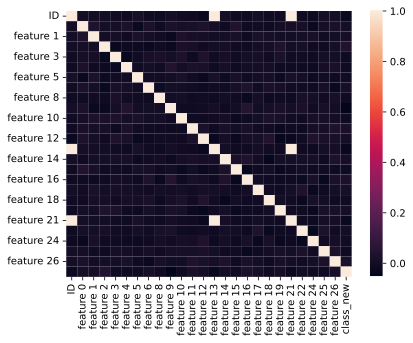

In [42]:
sns.heatmap(df_1.corr())

In [43]:
trashhold = 0.8

In [44]:
corr_cols = [] #

for col in df_1.columns:
    for col_2 in df_1.columns:
        if (col != col_2) and ((df_1[col].corr(df_1[col_2]) >= trashhold or df_1[col].corr(df_1[col_2]) <= -trashhold)):
            corr_cols.append(col)
            print(f'{col} - {col_2}: {df_1[col].corr(df_1[col_2])}')
            print()

ID - feature 13: 0.9999173908420722

ID - feature 21: 0.9999407548203347

feature 13 - ID: 0.9999173908420722

feature 13 - feature 21: 0.999975683260246

feature 21 - ID: 0.9999407548203346

feature 21 - feature 13: 0.999975683260246



Удалим лишние признаки

In [45]:
df_1 = df_1.drop(['feature 13'
                    , 'feature 21'
                   ], axis=1)

In [46]:
df_1 = df_1.drop(['ID'], axis=1)

In [47]:
cat_col = []
num_col = []
for col in df_1.columns:
    print(f'Столбец "{col}": количество уникальных значений {df_1[col].nunique()}')

Столбец "feature 0": количество уникальных значений 3500
Столбец "feature 1": количество уникальных значений 3500
Столбец "feature 2": количество уникальных значений 3500
Столбец "feature 3": количество уникальных значений 3500
Столбец "feature 4": количество уникальных значений 3500
Столбец "feature 5": количество уникальных значений 3500
Столбец "feature 6": количество уникальных значений 3500
Столбец "feature 8": количество уникальных значений 3500
Столбец "feature 9": количество уникальных значений 3500
Столбец "feature 10": количество уникальных значений 3500
Столбец "feature 11": количество уникальных значений 3500
Столбец "feature 12": количество уникальных значений 3500
Столбец "feature 14": количество уникальных значений 3500
Столбец "feature 15": количество уникальных значений 3500
Столбец "feature 16": количество уникальных значений 3500
Столбец "feature 17": количество уникальных значений 3500
Столбец "feature 18": количество уникальных значений 3500
Столбец "feature 19": к

Посмотрим на значение дисперсии признаков, удали те, где дисперсия незначительная как малозначимые (меньше 10)

In [48]:
lowvar_col = []
for col in df_1.columns:
    if df_1[col].var(ddof=0) <= 2:
        lowvar_col.append(col)
        print(f'Столбец "{col}": значение дисперсии {df_1[col].var(ddof=0)}')

Столбец "feature 0": значение дисперсии 0.4118104762519767
Столбец "feature 3": значение дисперсии 1.007415185682336
Столбец "feature 4": значение дисперсии 1.0174483111125174
Столбец "feature 10": значение дисперсии 1.0380663732325242
Столбец "feature 11": значение дисперсии 0.004160916251075162
Столбец "feature 14": значение дисперсии 0.9627977272172318
Столбец "feature 19": значение дисперсии 0.979121057246252
Столбец "feature 22": значение дисперсии 1.9592110323814198
Столбец "feature 24": значение дисперсии 0.8796593439407492
Столбец "feature 25": значение дисперсии 0.0322994676382376
Столбец "class_new": значение дисперсии 0.9999791020408163


Удалим "мусорные" фичи

In [49]:
df_11 = df_1.drop(lowvar_col, axis=1)

In [50]:
df_11.head()

,feature 1,feature 2,feature 5,feature 6,feature 8,feature 9,feature 12,feature 15,feature 16,feature 17,feature 18,feature 26
0,4.219830,1.221181,3.717548,-5.371620,-8.114714,5.265328,11.258733,-1.817709,0.451489,0.484978,5.709929,6.044972
1,-3.151896,-0.084847,5.007462,1.150248,-2.975189,1.613209,-1.704318,0.921713,2.372759,2.378392,2.316058,6.032597
2,-0.705611,0.658260,3.570199,2.622817,2.182189,0.328124,3.220057,-0.818774,-1.073346,5.225690,9.047253,8.970672
5,-1.429901,-0.106532,4.423871,1.232094,5.498164,1.050433,2.092798,1.353735,2.042800,3.800421,9.422421,8.931144
6,3.351338,-4.389428,1.631655,0.538942,-2.159392,1.156437,4.716462,0.651614,3.037415,1.030021,2.670114,5.298785


In [67]:
f1 = df_11.columns

In [55]:
df_12 = df_11

In [56]:
df_12 = get_scale(df_12, MinMaxScaler())

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [57]:
df_12

array([[0.6591276 , 0.60996205, 0.60207374, ..., 0.06493121, 0.59566101,
        0.65364375],
       [0.32387673, 0.55442203, 0.81102228, ..., 0.32210183, 0.2414174 ,
        0.65230512],
       [0.4351287 , 0.58602335, 0.57820532, ..., 0.70883266, 0.94400248,
        0.97011021],
       ...,
       [0.37904056, 0.61813987, 0.26758164, ..., 0.2428861 , 0.55273353,
        0.5840036 ],
       [0.45352028, 0.59648946, 0.06418379, ..., 0.02119691, 0.29657475,
        0.76813029],
       [0.46154294, 0.68011543, 0.24132677, ..., 0.57536474, 0.42639596,
        0.8227381 ]])

Поменяем метки классов

In [45]:
# df_1.loc[df_1['class_new'] == 2, 'class_new'] = 1

### Обучение 1й  подмодели

In [58]:
X = df_12
y = df_1['class_new']

In [59]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создание и обучение модели CatBoost
cat_model = CatBoostClassifier()

In [60]:
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                'learning_rate' : [0.01,0.02,0.03,0.04],
                'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                }

In [61]:
Grid_CBC = GridSearchCV(estimator=cat_model, param_grid = parameters, cv = 4, n_jobs=-1)
Grid_CBC.fit(X_train, y_train)

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

0:	learn: 0.6920172	total: 172ms	remaining: 13.6s
1:	learn: 0.6899444	total: 198ms	remaining: 7.72s
2:	learn: 0.6883226	total: 221ms	remaining: 5.68s
3:	learn: 0.6866896	total: 250ms	remaining: 4.75s
4:	learn: 0.6851440	total: 283ms	remaining: 4.24s
5:	learn: 0.6838177	total: 308ms	remaining: 3.8s
6:	learn: 0.6823519	total: 340ms	remaining: 3.55s
7:	learn: 0.6810611	total: 364ms	remaining: 3.28s
8:	learn: 0.6798925	total: 388ms	remaining: 3.06s
9:	learn: 0.6785212	total: 411ms	remaining: 2.88s
10:	learn: 0.6774096	total: 435ms	remaining: 2.73s
11:	learn: 0.6758517	total: 467ms	remaining: 2.65s
12:	learn: 0.6749700	total: 498ms	remaining: 2.57s
13:	learn: 0.6736670	total: 522ms	remaining: 2.46s
14:	learn: 0.6722102	total: 547ms	remaining: 2.37s
15:	learn: 0.6709999	total: 579ms	remaining: 2.31s
16:	learn: 0.6694062	total: 603ms	remaining: 2.24s
17:	learn: 0.6679768	total: 631ms	remaining: 2.17s
18:	learn: 0.6665298	total: 652ms	remaining: 2.09s
19:	learn: 0.6654438	total: 675ms	remainin

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000249A4E3F9D0>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [62]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.520415507149026

 The best parameters across ALL searched params:
 {'depth': 9, 'iterations': 80, 'learning_rate': 0.04}


In [63]:
y_train_pred = Grid_CBC.predict(X_train)
y_test_pred = Grid_CBC.predict(X_test)

In [64]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1220
           2       0.90      0.94      0.92      1230

    accuracy                           0.92      2450
   macro avg       0.92      0.92      0.92      2450
weighted avg       0.92      0.92      0.92      2450

TEST

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       538
           2       0.50      0.55      0.52       512

    accuracy                           0.51      1050
   macro avg       0.51      0.51      0.51      1050
weighted avg       0.51      0.51      0.51      1050

CONFUSION MATRIX

col_0        0    2
class_new          
0          256  282
2          232  280


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [65]:
print('f1 score', f1_score(y_train, y_train_pred, average='macro'))

f1 score 0.9183215716396494


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [66]:
print('f1 score', f1_score(y_test, y_test_pred, average='macro'))

f1 score 0.5102203055746132


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

**1 часть тестовой выборки**

In [69]:
test2 = pd.read_csv('./Data/3semestr/Classification/test.csv')
test2.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26
0,3132,1.392138,-0.091924,-0.861607,-1.168089,0.729858,0.620246,-2.187895,8,-7.675251,...,6.186529,4.097432,-1.269949,1,3.083521,3.172888,9,3.640785,0.001478,1.702742
1,4371,2.122404,-0.948922,1.193036,0.971790,0.493626,4.255883,-1.749073,8,0.899573,...,5.300912,7.235901,-1.127997,1,4.294479,3.108627,9,-0.274482,0.125643,5.355107
2,6647,2.130981,-1.204017,3.480717,-2.275924,0.653080,0.409036,-2.807824,8,7.970245,...,7.221782,5.735965,0.758463,1,6.551737,2.545127,9,0.358025,0.554142,4.114993
3,5632,1.556761,-2.857128,2.885403,-0.110835,1.336319,4.275481,3.371328,8,3.727265,...,5.964860,2.026291,2.037987,1,5.534718,1.910816,9,-1.761030,0.111407,1.554630
4,9703,1.359874,2.200963,0.896334,-0.422109,-1.178996,1.635622,0.608625,8,-1.808741,...,6.362811,3.506961,0.683964,1,9.672132,3.973689,9,-2.018466,0.071259,3.625762


In [70]:
test2_target = pd.read_csv('urfu-engai-2023-competition-3-classification_1step.csv')
test2_target.head()

,ID,class_new
0,3132,1
1,4371,0
2,6647,0
3,5632,1
4,9703,0


In [71]:
test_1 = pd.merge(
    test2,
    test2_target,
    how="left",
    on='ID',
)
test_1.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
0,3132,1.392138,-0.091924,-0.861607,-1.168089,0.729858,0.620246,-2.187895,8,-7.675251,...,4.097432,-1.269949,1,3.083521,3.172888,9,3.640785,0.001478,1.702742,1
1,4371,2.122404,-0.948922,1.193036,0.971790,0.493626,4.255883,-1.749073,8,0.899573,...,7.235901,-1.127997,1,4.294479,3.108627,9,-0.274482,0.125643,5.355107,0
2,6647,2.130981,-1.204017,3.480717,-2.275924,0.653080,0.409036,-2.807824,8,7.970245,...,5.735965,0.758463,1,6.551737,2.545127,9,0.358025,0.554142,4.114993,0
3,5632,1.556761,-2.857128,2.885403,-0.110835,1.336319,4.275481,3.371328,8,3.727265,...,2.026291,2.037987,1,5.534718,1.910816,9,-1.761030,0.111407,1.554630,1
4,9703,1.359874,2.200963,0.896334,-0.422109,-1.178996,1.635622,0.608625,8,-1.808741,...,3.506961,0.683964,1,9.672132,3.973689,9,-2.018466,0.071259,3.625762,0


In [72]:
test_1 = test_1.loc[(test_1['class_new'] == 0)]
test_1.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
1,4371,2.122404,-0.948922,1.193036,0.971790,0.493626,4.255883,-1.749073,8,0.899573,...,7.235901,-1.127997,1,4.294479,3.108627,9,-0.274482,0.125643,5.355107,0
2,6647,2.130981,-1.204017,3.480717,-2.275924,0.653080,0.409036,-2.807824,8,7.970245,...,5.735965,0.758463,1,6.551737,2.545127,9,0.358025,0.554142,4.114993,0
4,9703,1.359874,2.200963,0.896334,-0.422109,-1.178996,1.635622,0.608625,8,-1.808741,...,3.506961,0.683964,1,9.672132,3.973689,9,-2.018466,0.071259,3.625762,0
7,1188,1.156563,4.079438,0.249911,-1.601310,0.621432,2.179092,3.401504,8,-1.208711,...,1.276852,0.614489,1,1.161390,0.987519,9,-1.129180,0.530305,3.831362,0
8,5114,1.798290,-2.972950,-0.257655,1.255526,0.971318,2.289483,0.581975,8,6.265300,...,5.686732,1.316995,1,5.030840,4.468227,9,-1.987546,0.370212,3.959151,0


In [73]:
test_1.shape

(1420, 29)

Сохраним 1ю часть результатов

In [74]:
test_1_submission_clf = test_1[['ID', 'class_new']]
test_1_submission_clf

,ID,class_new
1,4371,0
2,6647,0
4,9703,0
7,1188,0
8,5114,0
...,...,...
2980,81,0
2984,4739,0
2987,5335,0
2993,203,0


In [75]:
test_1_submission_clf.to_csv('urfu-engai-2023-competition-3-classification_1mod_sub.csv', index=False)

In [76]:
test_11 = test_1[f1]

In [77]:
test_11 = get_scale(test_11, MinMaxScaler())

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [78]:
test_11

array([[0.44873069, 0.56633059, 0.68893798, ..., 0.71986479, 0.7550928 ,
        0.57876562],
       [0.43621325, 0.68240002, 0.06522824, ..., 0.98090383, 0.59848349,
        0.4442608 ],
       [0.60329503, 0.55127691, 0.26410116, ..., 0.86417299, 0.36575181,
        0.39119803],
       ...,
       [0.43108613, 0.34933394, 0.29183432, ..., 0.76650907, 0.36215792,
        0.66190464],
       [0.55161508, 0.59590753, 0.07694491, ..., 0.59819592, 0.50008102,
        0.54522919],
       [0.63719049, 0.51598897, 0.42317006, ..., 0.32882722, 0.05326655,
        0.66624982]])

In [79]:
test_preds = Grid_CBC.predict(test_11)

In [80]:
test_preds

array([0, 2, 0, ..., 0, 0, 2], dtype=int64)

### Сохраним полученные предсказания

In [81]:
test_1_submission_clf['class_new'] = test_preds

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_35648\1364286292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1_submission_clf['class_new'] = test_preds


In [82]:
test_1_submission_clf

,ID,class_new
1,4371,0
2,6647,2
4,9703,0
7,1188,2
8,5114,2
...,...,...
2980,81,2
2984,4739,2
2987,5335,0
2993,203,0


In [83]:
#test_1_submission_clf.loc[test_1_submission_clf['class_new'] == 1, 'class_new'] = 2

#### Сохраним полученный промежуточный результат:

In [84]:
test_1_submission_clf.to_csv('urfu-engai-2023-competition-3-classification_2step.csv', index=False)

**3 и 1**

In [85]:
train3 = pd.read_csv('./Data/3semestr/Classification/train.csv')
train3.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26
0,6002,0.284313,4.219830,1.221181,-0.033805,0.954967,3.717548,-5.371620,8,-8.114714,...,0.484978,5.709929,0.419168,1,5.902307,0.025756,9,0.400968,0.200678,6.044972
1,4895,0.688878,-3.151896,-0.084847,0.837584,0.452307,5.007462,1.150248,8,-2.975189,...,2.378392,2.316058,-0.143171,1,4.830141,3.561733,9,0.025996,0.123487,6.032597
2,4072,1.924478,-0.705611,0.658260,0.367463,0.784745,3.570199,2.622817,8,2.182189,...,5.225690,9.047253,0.691782,1,4.018763,0.292715,9,0.223886,0.107620,8.970672
3,4457,2.012251,2.732572,2.831323,0.470805,-1.067754,5.178344,2.087656,8,-1.931267,...,1.050520,4.689684,-0.183979,1,4.378999,4.398202,9,0.199916,0.556204,4.974319
4,7880,1.405036,-4.750124,-6.526375,-0.770324,0.549478,3.790355,-0.193960,8,-7.969943,...,0.479188,6.697533,2.232350,1,7.818239,3.371134,9,-0.886806,0.576564,4.763733


In [86]:
df_2 = pd.merge(
    train3,
    target,
    how="left",
    on='ID',
)
df_2.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
0,6002,0.284313,4.219830,1.221181,-0.033805,0.954967,3.717548,-5.371620,8,-8.114714,...,5.709929,0.419168,1,5.902307,0.025756,9,0.400968,0.200678,6.044972,2
1,4895,0.688878,-3.151896,-0.084847,0.837584,0.452307,5.007462,1.150248,8,-2.975189,...,2.316058,-0.143171,1,4.830141,3.561733,9,0.025996,0.123487,6.032597,0
2,4072,1.924478,-0.705611,0.658260,0.367463,0.784745,3.570199,2.622817,8,2.182189,...,9.047253,0.691782,1,4.018763,0.292715,9,0.223886,0.107620,8.970672,2
3,4457,2.012251,2.732572,2.831323,0.470805,-1.067754,5.178344,2.087656,8,-1.931267,...,4.689684,-0.183979,1,4.378999,4.398202,9,0.199916,0.556204,4.974319,1
4,7880,1.405036,-4.750124,-6.526375,-0.770324,0.549478,3.790355,-0.193960,8,-7.969943,...,6.697533,2.232350,1,7.818239,3.371134,9,-0.886806,0.576564,4.763733,3


In [87]:
df_2 = df_2.loc[(df_2['class_new'] == 1) | (df_2['class_new'] == 3)]
df_2.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
3,4457,2.012251,2.732572,2.831323,0.470805,-1.067754,5.178344,2.087656,8,-1.931267,...,4.689684,-0.183979,1,4.378999,4.398202,9,0.199916,0.556204,4.974319,1
4,7880,1.405036,-4.750124,-6.526375,-0.770324,0.549478,3.790355,-0.193960,8,-7.969943,...,6.697533,2.232350,1,7.818239,3.371134,9,-0.886806,0.576564,4.763733,3
7,8470,0.144365,-0.312750,-1.171075,-0.467713,1.411748,3.539197,0.353315,8,-2.188391,...,1.986388,1.065724,1,8.413568,2.528117,9,-0.760276,0.283767,2.556277,1
9,5584,0.843800,1.369740,-0.950517,0.543815,1.618422,2.855754,2.014999,8,7.095416,...,5.112956,1.450434,1,5.480215,2.213441,9,3.426876,0.006631,2.564379,3
10,4046,0.162279,-1.751492,-3.728324,0.111039,-0.404946,1.201294,1.524360,8,7.325262,...,6.928794,0.319174,1,3.985592,1.834651,9,1.766956,0.267474,1.024916,1


In [88]:
df_2.shape

(3500, 29)

Составим список признаков, у которых более 95% строк содержат одно и то же значение

In [89]:
trashhold = 0.95

In [90]:
num_rows = len(df_2.index)
low_information_cols = [] #

for col in df_2.columns:
    cnts = df_2[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > trashhold:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

feature 7: 100.00000%
feature 7
8    3500
Name: count, dtype: int64

feature 20: 100.00000%
feature 20
1    3500
Name: count, dtype: int64

feature 23: 100.00000%
feature 23
9    3500
Name: count, dtype: int64



Удалим эти признаки

In [91]:
df_2 = df_2.drop(low_information_cols, axis=1)

Построим тепловую карту корреляции признаков

<Axes: >

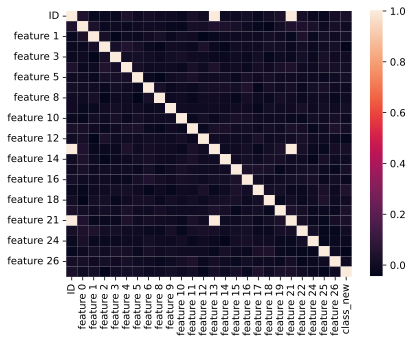

In [92]:
sns.heatmap(df_2.corr())

In [93]:
trashhold = 0.8

In [94]:
corr_cols = [] #

for col in df_2.columns:
    for col_2 in df_2.columns:
        if (col != col_2) and ((df_2[col].corr(df_2[col_2]) >= trashhold or df_2[col].corr(df_2[col_2]) <= -trashhold)):
            corr_cols.append(col)
            print(f'{col} - {col_2}: {df_2[col].corr(df_2[col_2])}')
            print()

ID - feature 13: 0.9999193713625567

ID - feature 21: 0.9999432837493892

feature 13 - ID: 0.9999193713625566

feature 13 - feature 21: 0.9999763803668261

feature 21 - ID: 0.9999432837493891

feature 21 - feature 13: 0.9999763803668261



Удалим лишние признаки

In [45]:
df_2 = df_2.drop(['feature 13'
                    , 'feature 21'
                   ], axis=1)

In [95]:
df_2 = df_2.drop(['ID'], axis=1)

In [96]:
cat_col = []
num_col = []
for col in df_1.columns:
    print(f'Столбец "{col}": количество уникальных значений {df_1[col].nunique()}')

Столбец "feature 0": количество уникальных значений 3500
Столбец "feature 1": количество уникальных значений 3500
Столбец "feature 2": количество уникальных значений 3500
Столбец "feature 3": количество уникальных значений 3500
Столбец "feature 4": количество уникальных значений 3500
Столбец "feature 5": количество уникальных значений 3500
Столбец "feature 6": количество уникальных значений 3500
Столбец "feature 8": количество уникальных значений 3500
Столбец "feature 9": количество уникальных значений 3500
Столбец "feature 10": количество уникальных значений 3500
Столбец "feature 11": количество уникальных значений 3500
Столбец "feature 12": количество уникальных значений 3500
Столбец "feature 14": количество уникальных значений 3500
Столбец "feature 15": количество уникальных значений 3500
Столбец "feature 16": количество уникальных значений 3500
Столбец "feature 17": количество уникальных значений 3500
Столбец "feature 18": количество уникальных значений 3500
Столбец "feature 19": к

Посмотрим на значение дисперсии признаков, удали те, где дисперсия незначительная как малозначимые (меньше 10)

In [97]:
lowvar_col = []
for col in df_2.columns:
    if df_2[col].var(ddof=0) <= 2:
        lowvar_col.append(col)
        print(f'Столбец "{col}": значение дисперсии {df_2[col].var(ddof=0)}')

Столбец "feature 0": значение дисперсии 0.3903274096511624
Столбец "feature 3": значение дисперсии 0.9975531896550233
Столбец "feature 4": значение дисперсии 0.9904756027090954
Столбец "feature 10": значение дисперсии 1.0423530822046534
Столбец "feature 11": значение дисперсии 0.004348239782093194
Столбец "feature 19": значение дисперсии 0.9929174787762448
Столбец "feature 25": значение дисперсии 0.03231536684199983
Столбец "class_new": значение дисперсии 0.9994511020408163


Удалим "мусорные" фичи

In [98]:
df_21 = df_2.drop(lowvar_col, axis=1)

In [99]:
df_21.head()

,feature 1,feature 2,feature 5,feature 6,feature 8,feature 9,feature 12,feature 13,feature 14,feature 15,feature 16,feature 17,feature 18,feature 21,feature 22,feature 24,feature 26
3,2.732572,2.831323,5.178344,2.087656,-1.931267,3.506177,5.513759,10.759875,-3.324491,2.346552,-1.771180,1.050520,4.689684,4.378999,4.398202,0.199916,4.974319
4,-4.750124,-6.526375,3.790355,-0.193960,-7.969943,1.945758,2.836082,17.618619,-2.859016,1.117392,0.351779,0.479188,6.697533,7.818239,3.371134,-0.886806,4.763733
7,-0.312750,-1.171075,3.539197,0.353315,-2.188391,1.271629,-0.877871,18.860306,-2.175143,1.900528,-0.009178,5.369977,1.986388,8.413568,2.528117,-0.760276,2.556277
9,1.369740,-0.950517,2.855754,2.014999,7.095416,3.827908,3.642012,12.933989,0.623397,-1.657076,4.723745,3.565478,5.112956,5.480215,2.213441,3.426876,2.564379
10,-1.751492,-3.728324,1.201294,1.524360,7.325262,3.445063,-4.352504,9.994275,1.106756,-2.009627,-1.228933,1.977632,6.928794,3.985592,1.834651,1.766956,1.024916


In [101]:
f2 = df_21.columns

In [102]:
df_21 = df_2[f2]

In [103]:
df_22 = get_scale(df_21, MinMaxScaler())

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [104]:
df_22

array([[0.62815564, 0.65818907, 0.83863059, ..., 0.90201297, 0.47132398,
        0.53801585],
       [0.31133586, 0.19586298, 0.61372362, ..., 0.69130492, 0.38501492,
        0.51521991],
       [0.49921571, 0.46044675, 0.57302656, ..., 0.51835566, 0.39506416,
        0.27626279],
       ...,
       [0.47098056, 0.35734217, 0.20393097, ..., 0.34962655, 0.68942739,
        0.23078605],
       [0.5843165 , 0.5288741 , 0.23412457, ..., 0.63994836, 0.66740825,
        0.26092847],
       [0.48351139, 0.42122112, 0.85284264, ..., 0.0508701 , 0.79632953,
        0.58412235]])

Поменяем метки классов

In [355]:
# df_2.loc[df_2['class_new'] == 3, 'class_new'] = 0

### Обучение 2й  подмодели

In [105]:
X = df_22
y = df_2['class_new']

In [106]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создание и обучение модели CatBoost
cat_model = CatBoostClassifier()

In [107]:
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                'learning_rate' : [0.01,0.02,0.03,0.04],
                'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                }

In [108]:
Grid_CBC = GridSearchCV(estimator=cat_model, param_grid = parameters, cv = 4, n_jobs=-1)
Grid_CBC.fit(X_train, y_train)

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

0:	learn: 0.6926720	total: 7.22ms	remaining: 209ms
1:	learn: 0.6921023	total: 17ms	remaining: 238ms
2:	learn: 0.6914731	total: 24.4ms	remaining: 220ms
3:	learn: 0.6909413	total: 31.6ms	remaining: 205ms
4:	learn: 0.6901646	total: 38.5ms	remaining: 193ms
5:	learn: 0.6895763	total: 48.9ms	remaining: 196ms
6:	learn: 0.6886832	total: 57.5ms	remaining: 189ms
7:	learn: 0.6879178	total: 66.7ms	remaining: 184ms
8:	learn: 0.6872769	total: 73.1ms	remaining: 171ms
9:	learn: 0.6867797	total: 79.6ms	remaining: 159ms
10:	learn: 0.6858915	total: 86.2ms	remaining: 149ms
11:	learn: 0.6849968	total: 92.8ms	remaining: 139ms
12:	learn: 0.6846382	total: 98.7ms	remaining: 129ms
13:	learn: 0.6840485	total: 105ms	remaining: 120ms
14:	learn: 0.6834677	total: 111ms	remaining: 111ms
15:	learn: 0.6828773	total: 118ms	remaining: 103ms
16:	learn: 0.6824327	total: 125ms	remaining: 95.7ms
17:	learn: 0.6818193	total: 132ms	remaining: 87.7ms
18:	learn: 0.6811143	total: 138ms	remaining: 79.8ms
19:	learn: 0.6805122	total:

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000249A76B3520>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [109]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.5273399599100108

 The best parameters across ALL searched params:
 {'depth': 7, 'iterations': 30, 'learning_rate': 0.03}


In [110]:
y_train_pred = Grid_CBC.predict(X_train)
y_test_pred = Grid_CBC.predict(X_test)

In [111]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           1       0.69      0.95      0.80      1264
           3       0.91      0.54      0.67      1186

    accuracy                           0.75      2450
   macro avg       0.80      0.74      0.73      2450
weighted avg       0.79      0.75      0.74      2450

TEST

              precision    recall  f1-score   support

           1       0.50      0.76      0.60       527
           3       0.50      0.24      0.32       523

    accuracy                           0.50      1050
   macro avg       0.50      0.50      0.46      1050
weighted avg       0.50      0.50      0.46      1050

CONFUSION MATRIX

col_0        1    3
class_new          
1          399  128
3          397  126


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [112]:
print('f1 score', f1_score(y_train, y_train_pred, average='macro'))

f1 score 0.7348799767739552


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [113]:
print('f1 score', f1_score(y_test, y_test_pred, average='macro'))

f1 score 0.46374946374946374


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

**2 часть тестовой выборки**

In [114]:
test3 = pd.read_csv('./Data/3semestr/Classification/test.csv')
test3.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26
0,3132,1.392138,-0.091924,-0.861607,-1.168089,0.729858,0.620246,-2.187895,8,-7.675251,...,6.186529,4.097432,-1.269949,1,3.083521,3.172888,9,3.640785,0.001478,1.702742
1,4371,2.122404,-0.948922,1.193036,0.971790,0.493626,4.255883,-1.749073,8,0.899573,...,5.300912,7.235901,-1.127997,1,4.294479,3.108627,9,-0.274482,0.125643,5.355107
2,6647,2.130981,-1.204017,3.480717,-2.275924,0.653080,0.409036,-2.807824,8,7.970245,...,7.221782,5.735965,0.758463,1,6.551737,2.545127,9,0.358025,0.554142,4.114993
3,5632,1.556761,-2.857128,2.885403,-0.110835,1.336319,4.275481,3.371328,8,3.727265,...,5.964860,2.026291,2.037987,1,5.534718,1.910816,9,-1.761030,0.111407,1.554630
4,9703,1.359874,2.200963,0.896334,-0.422109,-1.178996,1.635622,0.608625,8,-1.808741,...,6.362811,3.506961,0.683964,1,9.672132,3.973689,9,-2.018466,0.071259,3.625762


In [115]:
test3_target = pd.read_csv('urfu-engai-2023-competition-3-classification_1step.csv')
test3_target.head()

,ID,class_new
0,3132,1
1,4371,0
2,6647,0
3,5632,1
4,9703,0


In [116]:
test_2 = pd.merge(
    test3,
    test3_target,
    how="left",
    on='ID',
)
test_2.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
0,3132,1.392138,-0.091924,-0.861607,-1.168089,0.729858,0.620246,-2.187895,8,-7.675251,...,4.097432,-1.269949,1,3.083521,3.172888,9,3.640785,0.001478,1.702742,1
1,4371,2.122404,-0.948922,1.193036,0.971790,0.493626,4.255883,-1.749073,8,0.899573,...,7.235901,-1.127997,1,4.294479,3.108627,9,-0.274482,0.125643,5.355107,0
2,6647,2.130981,-1.204017,3.480717,-2.275924,0.653080,0.409036,-2.807824,8,7.970245,...,5.735965,0.758463,1,6.551737,2.545127,9,0.358025,0.554142,4.114993,0
3,5632,1.556761,-2.857128,2.885403,-0.110835,1.336319,4.275481,3.371328,8,3.727265,...,2.026291,2.037987,1,5.534718,1.910816,9,-1.761030,0.111407,1.554630,1
4,9703,1.359874,2.200963,0.896334,-0.422109,-1.178996,1.635622,0.608625,8,-1.808741,...,3.506961,0.683964,1,9.672132,3.973689,9,-2.018466,0.071259,3.625762,0


In [117]:
test_2 = test_2.loc[(test_2['class_new'] == 1)]
test_2.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,class_new
0,3132,1.392138,-0.091924,-0.861607,-1.168089,0.729858,0.620246,-2.187895,8,-7.675251,...,4.097432,-1.269949,1,3.083521,3.172888,9,3.640785,0.001478,1.702742,1
3,5632,1.556761,-2.857128,2.885403,-0.110835,1.336319,4.275481,3.371328,8,3.727265,...,2.026291,2.037987,1,5.534718,1.910816,9,-1.761030,0.111407,1.554630,1
5,2046,1.198144,-6.133336,-0.985011,0.356860,-1.388931,5.484968,-2.928490,8,3.615976,...,5.277108,-0.380624,1,2.002820,3.464783,9,-0.971535,0.369060,1.041748,1
6,5651,2.088715,0.993158,0.148910,0.875875,0.066828,4.088246,-0.858357,8,-3.332726,...,6.498057,0.919678,1,5.548068,4.689583,9,-0.118837,0.245111,4.464472,1
12,4984,1.793526,0.141782,0.085277,0.073553,-0.567961,0.876482,1.581258,8,1.556327,...,5.328742,0.305491,1,4.915142,3.243907,9,2.062348,0.345239,2.767371,1


In [118]:
test_2.shape

(1580, 29)

Сохраним 2ю часть результатов

In [119]:
test_2_submission_clf = test_2[['ID', 'class_new']]
test_2_submission_clf

,ID,class_new
0,3132,1
3,5632,1
5,2046,1
6,5651,1
12,4984,1
...,...,...
2994,5346,1
2995,7604,1
2996,2727,1
2998,977,1


In [120]:
test_2_submission_clf.to_csv('urfu-engai-2023-competition-3-classification_2mod_sub.csv', index=False)

In [121]:
test_21 = test_2[f2]

In [122]:
test_21 = get_scale(test_21, MinMaxScaler())

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [123]:
test_21

array([[0.46477187, 0.53013365, 0.10030806, ..., 0.65055549, 0.74260815,
        0.1823295 ],
       [0.3100853 , 0.70531693, 0.69249434, ..., 0.39123057, 0.32556699,
        0.1662719 ],
       [0.12681291, 0.52436417, 0.88844386, ..., 0.71053264, 0.38651907,
        0.11066763],
       ...,
       [0.46306962, 0.57506542, 0.08921148, ..., 0.40163818, 0.39739099,
        0.91618711],
       [0.31841826, 0.69189741, 0.5783155 , ..., 0.90460394, 0.42730661,
        0.71245911],
       [0.17353278, 0.38818403, 0.32050126, ..., 0.40079523, 0.45110727,
        0.30024415]])

In [124]:
test_preds = Grid_CBC.predict(test_21)

In [125]:
test_preds

array([1, 1, 3, ..., 1, 1, 1], dtype=int64)

### Сохраним полученные предсказания

In [126]:
test_2_submission_clf['class_new'] = test_preds

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_35648\1741646425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2_submission_clf['class_new'] = test_preds


In [127]:
test_2_submission_clf

,ID,class_new
0,3132,1
3,5632,1
5,2046,3
6,5651,1
12,4984,1
...,...,...
2994,5346,1
2995,7604,1
2996,2727,1
2998,977,1


In [128]:
# test_2_submission_clf.loc[test_2_submission_clf['class_new'] == 0, 'class_new'] = 3

#### Сохраним полученный промежуточный результат:

In [129]:
test_2_submission_clf.to_csv('urfu-engai-2023-competition-3-classification_3step.csv', index=False)

## Объединим полученные части

In [130]:
submission_clf = pd.concat([test_1_submission_clf, test_2_submission_clf], ignore_index=True)

In [131]:
submission_clf

,ID,class_new
0,4371,0
1,6647,2
2,9703,0
3,1188,2
4,5114,2
...,...,...
2995,5346,1
2996,7604,1
2997,2727,1
2998,977,1


#### Сохраним полученный результат:

In [132]:
submission_clf.to_csv('urfu-engai-2023-competition-3-classification_finalstep_v2.csv', index=False)

### Комментарии

Понятно, что ничего не понятно :((

Если останется время, то вернусь перед экзаменом

### Подтверждение результата лидерборда:

In [133]:
from IPython.display import Image

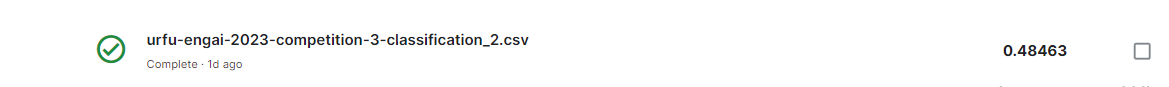

In [134]:
Image("3sem_clf_1.png", width=620, height=480) 

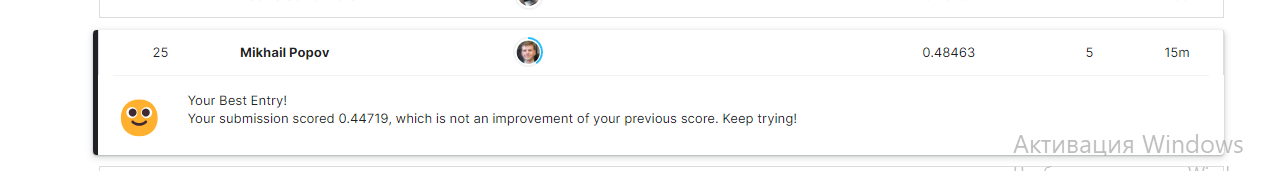

In [135]:
Image("3sem_clf_2.png", width=620, height=480) 